In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import IPython.display
import pickle
import os
from tqdm import tqdm
import collections
import json
import torch
import torch.nn.functional as F
import sys
import numpy as np


sys.path.append('..')
from src.train import Trainer
from src.utils import set_requires_grad
from clsmodel import mnist, stl10, afhq, vafhq

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


INFO: Using numpy backend


In [4]:
# load exp config
model_path = '/vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/AFHQVanilla/models/best.pth'

#data-folder-path
folder_path = '/vol/biomedic2/agk21/PhDLogs/datasets/AFHQ/afhq'

config = json.load(open(os.path.join(os.path.dirname(os.path.dirname(model_path)), 'exp-config.json'), 'r'))

config['classifier'] = vafhq(32, True).cuda(0)
# config['classifier'] = afhq(3, True).cuda(0)

model = Trainer(**config)
model.load_model(model_path)
model.eval()


# model defns
feature_extractor = model.feature_extractor
conti_classifier = model.classifier_baseline
dis_classifier = model.classifier_quantized
decoder = model.dec
codebook_sampler = model.modelclass


# set_requires_grad(classifier, False)
set_requires_grad(feature_extractor, False)
set_requires_grad(conti_classifier, False)
set_requires_grad(dis_classifier, False)
set_requires_grad(decoder, False)
set_requires_grad(codebook_sampler, False)
    

# required config variables 
image_size = model.input_size
latent_dim = model.latent_size
num_classes = model.nclasses

AFHQ weights loaded from  /vol/biomedic2/agk21/PhDLogs/codes/stylEX-extention/Classifier/Logs/AFHQVanilla/best.pth
Building data loader with 16 workers
True
3 2 2 2
FeatureExtractor: Total number of trainable params: 0/28640
ContiClassifier: Total number of trainable params: 0/3075
codebook: Total number of trainable params: 3185913/3185913
DisClassifier: Total number of trainable params: 1539/1539
Decoder: Total number of trainable params: 738771/738771
Model loaded from /vol/biomedic2/agk21/PhDLogs/codes/SYB3/LOGS/AFHQVanilla/models/best.pth, loaded epoch:7 with stats: {'loss': 0.67030734, 'f1': 0.9864804964539008, 'acc': 0.9864804964539008, 'rloss': 0.034157056}


In [5]:
from src.dataset import get

batch_size = 16
train_loader, test_loader = get(batch_size, 
                      data_root = folder_path, 
                      train=True, val=True, 
                      input_size = image_size,
                      num_workers=10)


orig_images = []; orig_labels = []
for (img_batch, label_batch, *context_batch) in tqdm(test_loader):
    img_batch = img_batch.cuda(0)
    label_batch = label_batch.cuda(0)
    orig_images.extend(img_batch)
    orig_labels.extend(label_batch)


labels_ = np.array([lb.cpu().numpy() for lb in orig_labels])
# generate sample dataset
def get_sample_data(N_datapoints = 10): 
    sample_images = []; sample_labels = []
    for ci in range(num_classes):
        idxs = np.where(labels_ == ci)[0]
        randidxs = idxs[np.random.randint(0, len(idxs), N_datapoints//num_classes)]

        for idx in randidxs:
            sample_images.append(orig_images[idx].unsqueeze(0))
            sample_labels.append(orig_labels[idx].unsqueeze(0))

    sample_images = torch.cat(sample_images, dim = 0)
    sample_labels = torch.cat(sample_labels, dim = 0)
    return sample_images, sample_labels

Building data loader with 10 workers


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:04<00:00, 20.58it/s]


511


915it [01:52,  8.10it/s]


114


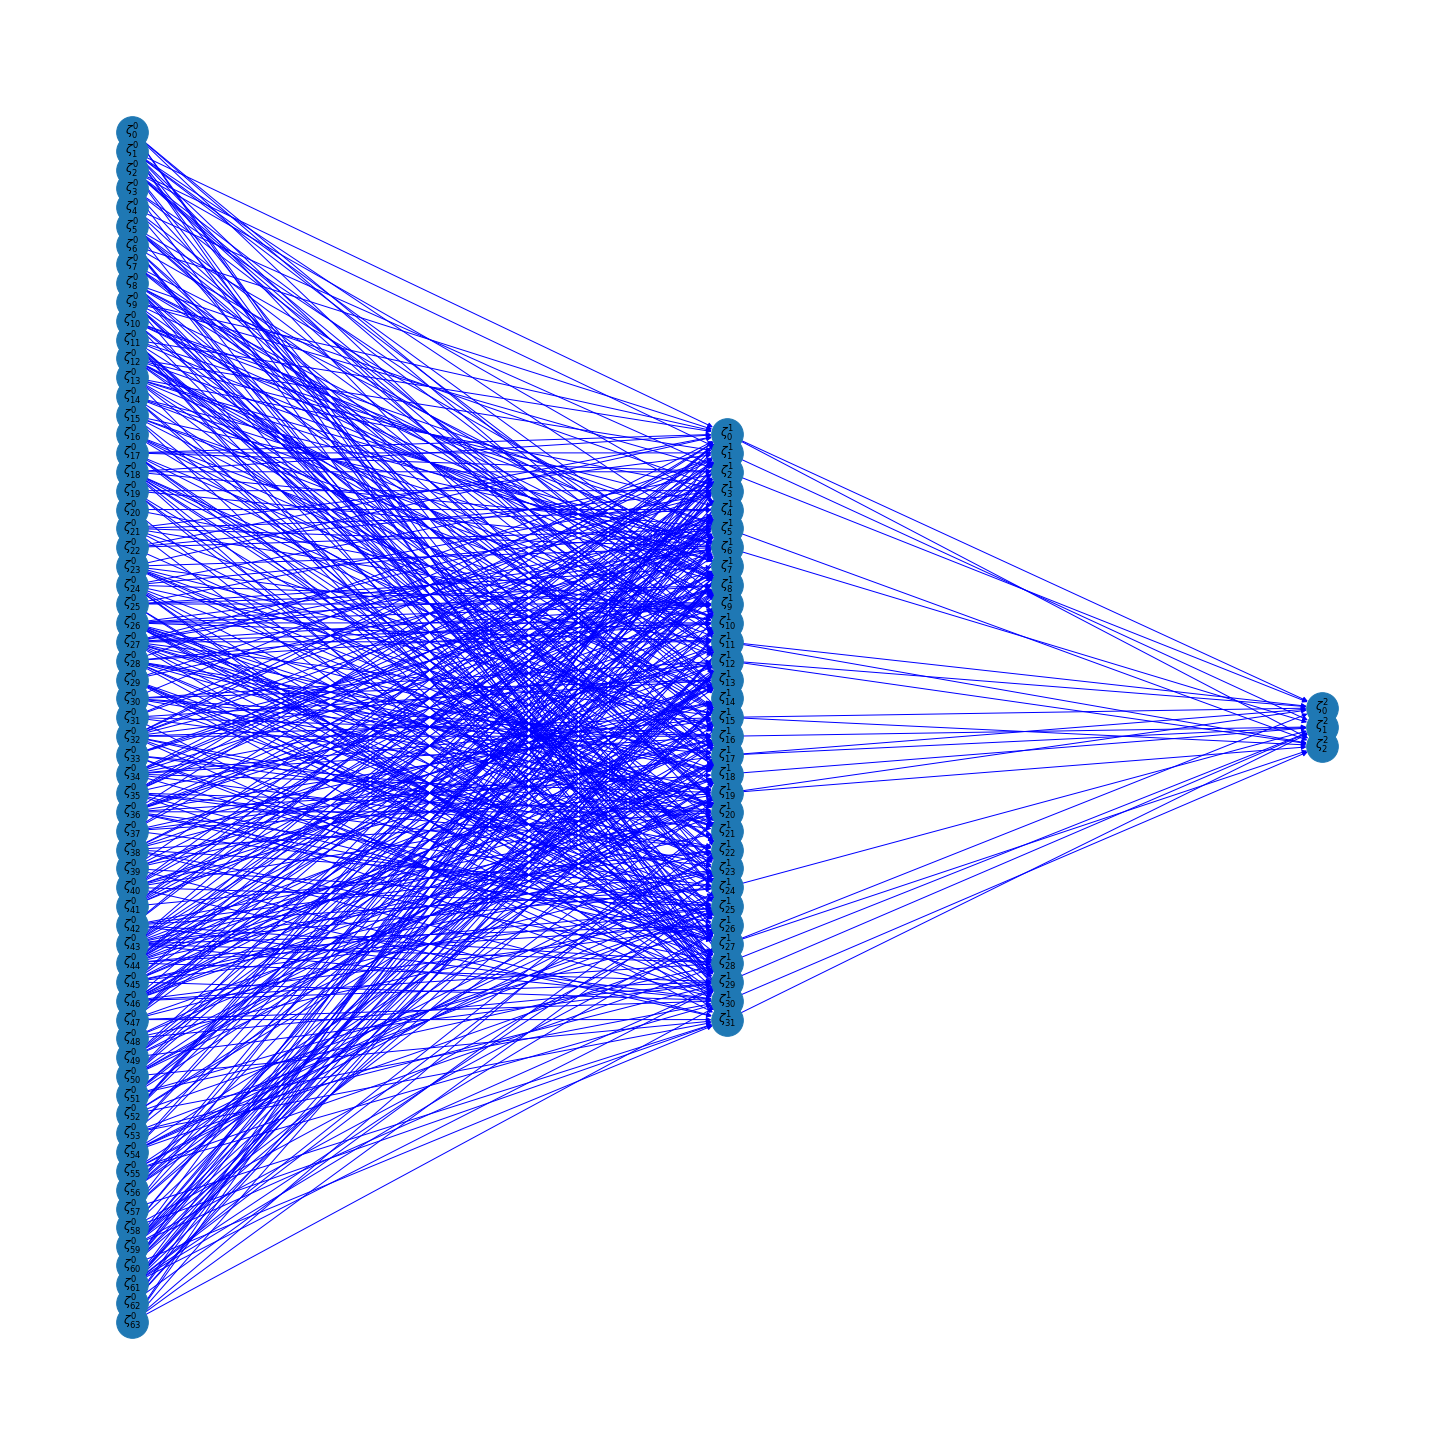

In [6]:
from src.inference import InductiveReasoningDT

inferer = InductiveReasoningDT(get_sample_data(100),
                               ncodebook_features = model.codebook_size,
                               nclasses = num_classes,
                               train_loader = train_loader,
                               feature_extractor = feature_extractor,
                               codebook = codebook_sampler,
                               classifier = dis_classifier,
                               decoder = decoder,
                               class_mapping = {0: 'cat', 1: 'dog', 2:'wild'})

                               

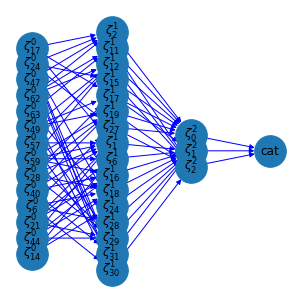

In [7]:
inferer.get_class_tree(0)

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{2}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{12}$', '$\\zeta^{1}_{15}$', '$\\zeta^{1}_{17}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{27}$'] [ 8 16 28 31]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{1}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{17}$', '$\\zeta^{1}_{18}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{28}$', '$\\zeta^{1}_{29}$', '$\\zeta^{1}_{31}$'] [ 8 16 28 31]
$\zeta^{2}_{2}$ ['$\\zeta^{1}_{11}$', '$\\zeta^{1}_{12}$', '$\\zeta^{1}_{15}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{30}$'] [ 8 16 28 31]
$\zeta^{1}_{16}$ ['$\\zeta^{0}_{21}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{59}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]
$\zeta^{1}_{28}$ ['$\\zeta^{0}_{6}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]
$\zeta^{1}_{31}$ ['$\\zeta^{0}_{24}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{47}$', '$\\zeta^{0}_{57}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]


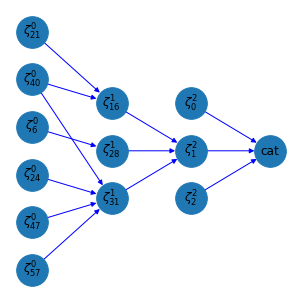

In [13]:
x,y = get_sample_data(num_classes)

class_idx = 0
x = x[class_idx].unsqueeze(0)

inferer.get_local_tree(class_idx, x)

$\zeta^{2}_{0}$ ['$\\zeta^{1}_{2}$', '$\\zeta^{1}_{11}$', '$\\zeta^{1}_{12}$', '$\\zeta^{1}_{15}$', '$\\zeta^{1}_{17}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{27}$'] [ 8 16 28 31]
$\zeta^{2}_{1}$ ['$\\zeta^{1}_{1}$', '$\\zeta^{1}_{6}$', '$\\zeta^{1}_{16}$', '$\\zeta^{1}_{17}$', '$\\zeta^{1}_{18}$', '$\\zeta^{1}_{24}$', '$\\zeta^{1}_{28}$', '$\\zeta^{1}_{29}$', '$\\zeta^{1}_{31}$'] [ 8 16 28 31]
$\zeta^{2}_{2}$ ['$\\zeta^{1}_{11}$', '$\\zeta^{1}_{12}$', '$\\zeta^{1}_{15}$', '$\\zeta^{1}_{19}$', '$\\zeta^{1}_{27}$', '$\\zeta^{1}_{30}$'] [ 8 16 28 31]
$\zeta^{1}_{16}$ ['$\\zeta^{0}_{21}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{44}$', '$\\zeta^{0}_{59}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]
$\zeta^{1}_{28}$ ['$\\zeta^{0}_{6}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]
$\zeta^{1}_{31}$ ['$\\zeta^{0}_{24}$', '$\\zeta^{0}_{40}$', '$\\zeta^{0}_{47}$', '$\\zeta^{0}_{57}$'] [ 1  3  6  8 11 14 17 18 21 24 26 33 34 38 40 47 49 50 53 57 62 63]
**

<Figure size 288x288 with 0 Axes>

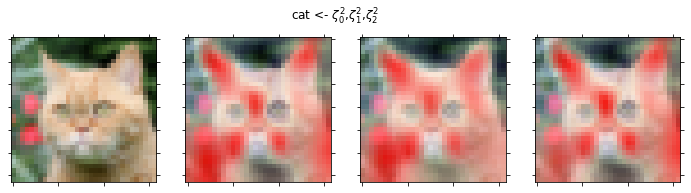

*************** Level-1 heirarchy **************
$\zeta^{2}_{1}$ <- $\zeta^{1}_{16}$,$\zeta^{1}_{28}$,$\zeta^{1}_{31}$


<Figure size 432x288 with 0 Axes>

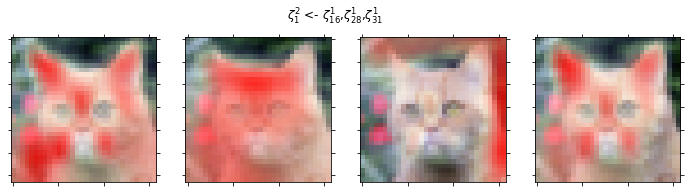

*************** Level-2 heirarchy **************
$\zeta^{1}_{16}$ <- $\zeta^{0}_{21}$,$\zeta^{0}_{40}$


<Figure size 432x288 with 0 Axes>

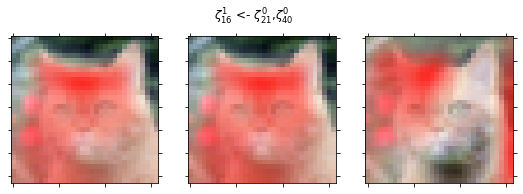

$\zeta^{1}_{28}$ <- $\zeta^{0}_{6}$


<Figure size 432x288 with 0 Axes>

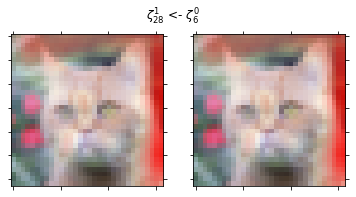

$\zeta^{1}_{31}$ <- $\zeta^{0}_{24}$,$\zeta^{0}_{40}$,$\zeta^{0}_{47}$,$\zeta^{0}_{57}$


<Figure size 432x288 with 0 Axes>

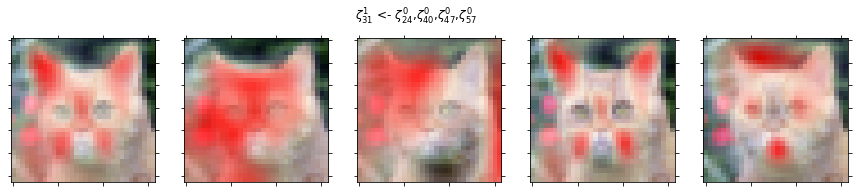

[['cat <- $\\zeta^{2}_{0}$,$\\zeta^{2}_{1}$,$\\zeta^{2}_{2}$'],
 ['$\\zeta^{2}_{1}$ <- $\\zeta^{1}_{16}$,$\\zeta^{1}_{28}$,$\\zeta^{1}_{31}$'],
 ['$\\zeta^{1}_{16}$ <- $\\zeta^{0}_{21}$,$\\zeta^{0}_{40}$',
  '$\\zeta^{1}_{28}$ <- $\\zeta^{0}_{6}$',
  '$\\zeta^{1}_{31}$ <- $\\zeta^{0}_{24}$,$\\zeta^{0}_{40}$,$\\zeta^{0}_{47}$,$\\zeta^{0}_{57}$']]

In [15]:

inferer.query(class_idx, visual = x, local=True, overlay=True, save_path='./Logs')